## **1. Mount google drive**
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to be current folder
import os
os.chdir('/content/drive/MyDrive/MyColab/coviddata')
!ls

Mounted at /content/drive
2020VAERSDATA.csv      data_complete2r.csv	vaers_data_complete_2021_09_06
2020VAERSSYMPTOMS.csv  data_complete_final.csv	vaers_data_complete_2021_09_08
2020VAERSVAX.csv       Model_09_10_10Symptoms	WordEmbedding
2021VAERSDATA.csv      model.bin		WordVec
2021VAERSSYMPTOMS.csv  test.txt
2021VAERSVAX.csv       TFIDF


## **2. Import the necessary libraries**
---

In [ ]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import os
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


print("Versions of key libraries")
print("---")
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
numpy:       1.19.5
matplotlib:  3.2.2
sklearn:     0.22.2.post1


In [ ]:
import pickle
#load the preprocessing data done in Bert Model
with open("data_complete_final.csv", "rb") as fp: 
  data_complete = pickle.load(fp)
print('data_complete2r loaded!')

data_complete2r loaded!


In [ ]:
#Perform down sampling on the least 4 frequent class
#sampled data will be concatenated back to dataframe_downsampling
sorted_columns = list(data_complete.iloc[:,2:].sum().sort_values().index)
dataframe_full = data_complete.copy()
dataframe_downsampling = pd.DataFrame(columns = data_complete.columns)
for column in sorted_columns[:4]:
  dataframe_concated = dataframe_full.loc[dataframe_full[column]==1].copy()
  dataframe_downsampling = pd.concat([dataframe_downsampling,dataframe_concated]).copy()
  dataframe_full = dataframe_full.loc[dataframe_full[column]==0].copy()

In [ ]:
#Perform down sampling on the least 8 frequent class
#sampled data will be concatenated back to dataframe_downsampling
sorted_columns_next = list(dataframe_downsampling.iloc[:,2:].sum().sort_values().index)
for column in sorted_columns_next[:8]:
  dataframe_concated = dataframe_full.loc[dataframe_full[column]==1].iloc[:1500,:].copy()
  dataframe_downsampling = pd.concat([dataframe_downsampling,dataframe_concated]).copy()
  dataframe_full = dataframe_full.loc[dataframe_full[column]==0].copy()

In [ ]:
#Perform down sampling on the least 8 frequent class
#sampled data will be concatenated back to dataframe_downsampling
sorted_columns_next2 = list(dataframe_downsampling.iloc[:,2:].sum().sort_values().index)
for column in sorted_columns_next2[:8]:
  dataframe_concated = dataframe_full.loc[dataframe_full[column]==1].iloc[:1500,:].copy()
  dataframe_downsampling = pd.concat([dataframe_downsampling,dataframe_concated]).copy()
  dataframe_full = dataframe_full.loc[dataframe_full[column]==0].copy()

In [ ]:
#Perform down sampling on the least 8 frequent class
#sampled data will be concatenated back to dataframe_downsampling
sorted_columns_next3 = list(dataframe_downsampling.iloc[:,2:].sum().sort_values().index)
for column in sorted_columns_next3[:8]:
  dataframe_concated = dataframe_full.loc[dataframe_full[column]==1].iloc[:1500,:].copy()
  dataframe_downsampling = pd.concat([dataframe_downsampling,dataframe_concated]).copy()
  dataframe_full = dataframe_full.loc[dataframe_full[column]==0].copy()

In [ ]:
#after down sampled dataset
dataframe_downsampling.iloc[:,2:].sum().sort_values()

SYMPTOMStroponin increased           1458.0
SYMPTOMSinjection site pruritus      1507.0
SYMPTOMSsars-cov-2 test positive     1671.0
SYMPTOMSlymphadenopathy              1776.0
SYMPTOMSsyncope                      1831.0
SYMPTOMSurticaria                    1892.0
SYMPTOMSparaesthesia                 1993.0
SYMPTOMSinjection site warmth        2008.0
SYMPTOMShyperhidrosis                2029.0
SYMPTOMSdiarrhoea                    2126.0
SYMPTOMSpulmonary embolism           2126.0
SYMPTOMSfeeling abnormal             2165.0
SYMPTOMScerebrovascular accident     2166.0
SYMPTOMSperipheral swelling          2333.0
SYMPTOMShypoaesthesia                2388.0
SYMPTOMScovid-19                     2460.0
SYMPTOMSchest pain                   2665.0
SYMPTOMSrash                         2707.0
SYMPTOMSmalaise                      2817.0
SYMPTOMSmyalgia                      2850.0
SYMPTOMSvomiting                     2875.0
SYMPTOMSasthenia                     3026.0
SYMPTOMSblood test              

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import spacy

#Text Processing
#lower casing the sentences
def lower_casing(sentence):
    new_sentence = sentence.lower()
    return new_sentence

#Abbreviation expansion
def expand_abbriviation(sentence):
    replacement_patterns = [
        (r'won\'t', 'will not'),
        (r'can\'t', 'cannot'),
        (r'i\'m', 'i am'),
        (r'ain\'t', 'is not'),
        (r'(\w+)\'ll', '\g<1> will'),
        (r'(\w+)n\'t', '\g<1> not'),
        (r'(\w+)\'ve', '\g<1> have'),
        (r'(\w+)\'s', '\g<1> is'),
        (r'(\w+)\'re', '\g<1> are'),
        (r'(\w+)\'d', '\g<1> would')]
    patterns = [(re.compile(regex), repl) for (regex, repl) in replacement_patterns]

    new_sentence = sentence
    for (pattern, repl) in patterns:
        (new_sentence, count) = re.subn(pattern, repl, new_sentence)
    return new_sentence

def remove_numbers(sentence):
    # define the pattern to keep
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', sentence)

#Punctuation removal
def punctuation_removal(sentence):
    # Remove the all the punctuations except '
    new_sentence = re.sub(';|\\\|:|,|!|\?|\"|<|>|\(|\)|\[|\]|\{|\}|@|#|\+|\=|\-|\_|~|\&|\*|\^|%|\||\$|/|`|\.|\'',
                          '', sentence,count=0, flags=0)
    return new_sentence

#Sentence tokenization
def tokenization(sentence):
    new_sentence = nltk.word_tokenize(sentence)
    return new_sentence

#Stopwords removal
def stopword_removal(sentence):
    stoplist = stopwords.words('english')
    new_sentence = [word for word in sentence if word not in stoplist]
    return new_sentence

#lemmatization
def get_wordnet_pos(word):
    pack = nltk.pos_tag([word])
    tag = pack[0][1]
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV

    else:
        return None

#lemmatization
def lemmatization(sentence):
    lemmatizer = nltk.stem.WordNetLemmatizer()

    new_sentence = [lemmatizer.lemmatize(word, get_wordnet_pos(word) or wordnet.NOUN) for word in sentence]

    return new_sentence

def text_preprocessing(raw_sentence):
    sentence = lower_casing(raw_sentence)
    sentence = expand_abbriviation(sentence)
    sentence = remove_numbers(sentence)
    sentence = punctuation_removal(sentence)
    sentence = tokenization(sentence)
    sentence = stopword_removal(sentence)
    sentence = lemmatization(sentence)
    sentence = ' '.join(sentence)
    return sentence


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#Execute text processing function on all single text
vaers_data_complete_text_processed = dataframe_downsampling['SYMPTOM_TEXT'].map(text_preprocessing)

In [ ]:
#define tokenizer and fit all proprocessed text into it
df_symptom_text_list = list(vaers_data_complete_text_processed)
tokenizer_full = Tokenizer()
tokenizer_full.fit_on_texts(df_symptom_text_list)
full_symptoms_tokenized = tokenizer_full.texts_to_sequences(df_symptom_text_list)
max_length = max([len(s.split()) for s in df_symptom_text_list])

In [ ]:
#tokenized the proprocessed dataset
import seaborn as sns
vocab_size = len(tokenizer_full.word_index) + 1
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_features=vocab_size, ngram_range=(1,2))
vectorizer.fit(vaers_data_complete_text_processed)
X = vectorizer.transform(vaers_data_complete_text_processed)
dic_vocabulary = vectorizer.vocabulary_

In [ ]:
#split dataset into train and test set
y = dataframe_downsampling.iloc[:,2:].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y.astype('int32'), test_size=0.1, random_state=42)

In [ ]:
#Define a pipeline combining a text feature extractor with multi lable classifier
#use multinomial naive bayse to test the performance
NB = OneVsRestClassifier(MultinomialNB())
NB.fit(X_train, y_train)
predicts = NB.predict(X_test)


In [ ]:
#custom Precision and Recall Curve created in Bert Model
def plot_pr_auc(y_test, y_score, classes):
    assert len(classes) > 1, "len classes must be > 1"
    plt.figure()
    if len(classes) > 2:  # multi-label
        # Compute ROC curve and ROC area for each class
        for i in range(len(classes)):
            precision, recall, _ = metrics.precision_recall_curve(y_test[:, i], y_score[:, i])
            pr_auc = metrics.auc(recall, precision)
            #plt.plot(recall, precision)
        # Compute micro-average ROC curve and ROC area
        precision, recall, _ = metrics.precision_recall_curve(y_test.ravel(), y_score.ravel())
        pr_auc = metrics.auc(recall, precision)
        # Plot ROC curve
        plt.plot(recall, precision, label='micro-average PR curve (area = {0:0.2f})'.format(pr_auc))
    else:
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
        pr_auc = metrics.auc(recall, precision)
        plt.plot(recall, precision, label='PR curve (area = {0:0.2f})'.format(pr_auc))
    #plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision recall')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig('BERT_roc.png')

In [ ]:
symptom_type   = list(dataframe_downsampling.iloc[:,2:].columns)
#performance checking on each classes
for index_symptoms in range(len(symptom_type)):
  testScores  = metrics.accuracy_score(y_test[:,index_symptoms],predicts[:,index_symptoms].round())


  print("Best accuracy (on testing dataset) for %s: %.2f%%" % (symptom_type[index_symptoms],testScores*100))
  precision, recall, _  = metrics.precision_recall_curve(y_test[:,index_symptoms],predicts[:,index_symptoms].round())
  auc_score = metrics.auc(recall, precision)
  print('AUC score: %.3f' % auc_score)
  print(metrics.classification_report(y_test[:,index_symptoms],
                                      predicts[:,index_symptoms].round(),
                                      target_names=['Not '+symptom_type[index_symptoms],symptom_type[index_symptoms]],
                                      digits=4))

Best accuracy (on testing dataset) for SYMPTOMSdyspnoea: 94.10%
AUC score: 0.628
                      precision    recall  f1-score   support

Not SYMPTOMSdyspnoea     0.9460    0.9921    0.9685      3676
    SYMPTOMSdyspnoea     0.8187    0.3864    0.5251       339

            accuracy                         0.9410      4015
           macro avg     0.8824    0.6893    0.7468      4015
        weighted avg     0.9353    0.9410    0.9311      4015

Best accuracy (on testing dataset) for SYMPTOMSpyrexia: 89.69%
AUC score: 0.677
                     precision    recall  f1-score   support

Not SYMPTOMSpyrexia     0.9082    0.9760    0.9409      3375
    SYMPTOMSpyrexia     0.7912    0.4797    0.5973       640

           accuracy                         0.8969      4015
          macro avg     0.8497    0.7278    0.7691      4015
       weighted avg     0.8895    0.8969    0.8861      4015

Best accuracy (on testing dataset) for SYMPTOMSchest pain: 94.92%
AUC score: 0.654
            

In [ ]:
#confusion matrix for each class
for index_symptoms in range(len(symptom_type)):
  confusion   = metrics.confusion_matrix(y_test[:,index_symptoms],predicts[:,index_symptoms])
  print(symptom_type[index_symptoms]+" Confusion Matrix:")
  print(confusion)
  print()

SYMPTOMSdyspnoea Confusion Matrix:
[[3647   29]
 [ 208  131]]

SYMPTOMSpyrexia Confusion Matrix:
[[3294   81]
 [ 333  307]]

SYMPTOMSchest pain Confusion Matrix:
[[3668   34]
 [ 170  143]]

SYMPTOMSheadache Confusion Matrix:
[[3200  111]
 [ 304  400]]

SYMPTOMSfatigue Confusion Matrix:
[[3443   30]
 [ 323  219]]

SYMPTOMScovid-19 Confusion Matrix:
[[3711   73]
 [  96  135]]

SYMPTOMSblood test Confusion Matrix:
[[3663   18]
 [ 298   36]]

SYMPTOMSnausea Confusion Matrix:
[[3519   15]
 [ 284  197]]

SYMPTOMSasthenia Confusion Matrix:
[[3717    5]
 [ 266   27]]

SYMPTOMScomputerised tomogram Confusion Matrix:
[[3565   91]
 [ 231  128]]

SYMPTOMSpain Confusion Matrix:
[[1946  468]
 [ 296 1305]]

SYMPTOMSdizziness Confusion Matrix:
[[3589   23]
 [ 258  145]]

SYMPTOMSsars-cov-2 test positive Confusion Matrix:
[[3804   39]
 [  83   89]]

SYMPTOMSvomiting Confusion Matrix:
[[3717    5]
 [ 232   61]]

SYMPTOMSchills Confusion Matrix:
[[3419   83]
 [ 240  273]]

SYMPTOMScerebrovascular acciden

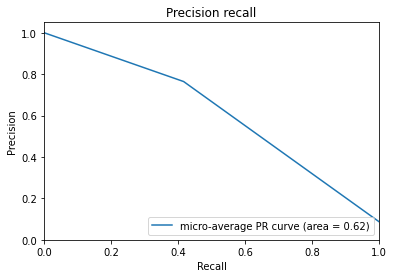

<Figure size 432x288 with 0 Axes>

In [ ]:
#hybrid model PR Curve
plot_pr_auc(y_test,predicts,symptom_type)

In [ ]:
#define SVM Model using One Vs Rest Classifier
SVCModel = OneVsRestClassifier(SVC())
SVCModel.fit(X_train, y_train)
predicts_SVC = SVCModel.predict(X_test)

In [ ]:
#performance checking on each classes
symptom_type   = list(dataframe_downsampling.iloc[:,2:].columns)

for index_symptoms in range(len(symptom_type)):
  testScores  = metrics.accuracy_score(y_test[:,index_symptoms],predicts_SVC[:,index_symptoms].round())

  print("Best accuracy (on testing dataset) for %s: %.2f%%" % (symptom_type[index_symptoms],testScores*100))
  precision, recall, _  = metrics.precision_recall_curve(y_test[:,index_symptoms],predicts_SVC[:,index_symptoms].round())
  auc_score = metrics.auc(recall, precision)
  print('AUC score: %.3f' % auc_score)
  print(metrics.classification_report(y_test[:,index_symptoms],
                                      predicts_SVC[:,index_symptoms].round(),
                                      target_names=['Not '+symptom_type[index_symptoms],symptom_type[index_symptoms]],
                                      digits=4))

Best accuracy (on testing dataset) for SYMPTOMSdyspnoea: 97.41%
AUC score: 0.850
                      precision    recall  f1-score   support

Not SYMPTOMSdyspnoea     0.9775    0.9946    0.9860      3676
    SYMPTOMSdyspnoea     0.9273    0.7522    0.8306       339

            accuracy                         0.9741      4015
           macro avg     0.9524    0.8734    0.9083      4015
        weighted avg     0.9733    0.9741    0.9729      4015

Best accuracy (on testing dataset) for SYMPTOMSpyrexia: 96.71%
AUC score: 0.905
                     precision    recall  f1-score   support

Not SYMPTOMSpyrexia     0.9743    0.9870    0.9806      3375
    SYMPTOMSpyrexia     0.9262    0.8625    0.8932       640

           accuracy                         0.9671      4015
          macro avg     0.9502    0.9247    0.9369      4015
       weighted avg     0.9666    0.9671    0.9666      4015

Best accuracy (on testing dataset) for SYMPTOMSchest pain: 98.21%
AUC score: 0.889
            

In [ ]:
#confusion matrix for each class
for index_symptoms in range(len(symptom_type)):
  confusion   = metrics.confusion_matrix(y_test[:,index_symptoms],predicts_SVC[:,index_symptoms])
  print(symptom_type[index_symptoms]+" Confusion Matrix:")
  print(confusion)
  print()

SYMPTOMSdyspnoea Confusion Matrix:
[[3656   20]
 [  84  255]]

SYMPTOMSpyrexia Confusion Matrix:
[[3331   44]
 [  88  552]]

SYMPTOMSchest pain Confusion Matrix:
[[3688   14]
 [  58  255]]

SYMPTOMSheadache Confusion Matrix:
[[3290   21]
 [  75  629]]

SYMPTOMSfatigue Confusion Matrix:
[[3466    7]
 [  64  478]]

SYMPTOMScovid-19 Confusion Matrix:
[[3756   28]
 [  66  165]]

SYMPTOMSblood test Confusion Matrix:
[[3673    8]
 [ 271   63]]

SYMPTOMSnausea Confusion Matrix:
[[3524   10]
 [  78  403]]

SYMPTOMSasthenia Confusion Matrix:
[[3706   16]
 [  97  196]]

SYMPTOMScomputerised tomogram Confusion Matrix:
[[3630   26]
 [ 268   91]]

SYMPTOMSpain Confusion Matrix:
[[2337   77]
 [ 167 1434]]

SYMPTOMSdizziness Confusion Matrix:
[[3597   15]
 [  93  310]]

SYMPTOMSsars-cov-2 test positive Confusion Matrix:
[[3830   13]
 [  63  109]]

SYMPTOMSvomiting Confusion Matrix:
[[3709   13]
 [  68  225]]

SYMPTOMSchills Confusion Matrix:
[[3484   18]
 [  51  462]]

SYMPTOMScerebrovascular acciden

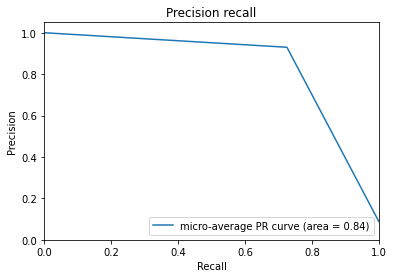

<Figure size 432x288 with 0 Axes>

In [ ]:
#hybrid model PR Curve
#better performance 0.87 but it was run in the local machine. Model has been uploaded. Can use the PRSPM_Hybrid to load and try the performance
plot_pr_auc(y_test,predicts_SVC,symptom_type)

In [ ]:
import pickle
import datetime
todayDate       = str(datetime.date.today())
filename = 'TFIDF/SVMModel_'+todayDate+'.sav'
pickle.dump(SVCModel,open(filename, 'wb'))

In [ ]:
filename = 'TFIDF/MultinomialModel_'+todayDate+'.sav'
pickle.dump(NB,open(filename, 'wb'))

In [ ]:
filename = 'TFIDF/TfidfVectorizer_'+todayDate+'.pkl'
pickle.dump(vectorizer,open(filename, 'wb'))